In [1]:
import pandas as pd
import numpy as np
#custom script to merge entries
import matplotlib.pyplot as plt
from pathlib import Path  
from utils import filter_by_column_value, plot_range_pie, count_nulls


# Goals of this notebook

Compute new features from stations metadata, from every available dataset, to potentially replace the stations names, with this metadata, providing the model with enough information to make good predictions without using one-hot encodings for every journey-destination pair

### Added features
1) Station busyness (from dutch stations dataset)
2) Distance between arrival/departure stations
3) Number of platforms? Out of scope
4) Daily trains? Out of scope

For now. Just distance between the stations and station size in one-hot encodings

In [2]:
stations = pd.read_csv('datasets/stations.csv')

In [3]:
stations.head()

,id,code,uic,name_short,name_medium,name_long,slug,country,type,geo_lat,geo_lng
0,266,HT,8400319,Den Bosch,'s-Hertogenbosch,'s-Hertogenbosch,s-hertogenbosch,NL,knooppuntIntercitystation,51.690480,5.293620
1,269,HTO,8400320,Dn Bosch O,'s-Hertogenb. O.,'s-Hertogenbosch Oost,s-hertogenbosch-oost,NL,stoptreinstation,51.700554,5.318333
2,227,HDE,8400388,'t Harde,'t Harde,'t Harde,t-harde,NL,stoptreinstation,52.409168,5.893611
3,8,AHBF,8015345,Aachen,Aachen Hbf,Aachen Hbf,aachen-hbf,D,knooppuntIntercitystation,50.767800,6.091499
4,818,AW,8015199,Aachen W,Aachen West,Aachen West,aachen-west,D,stoptreinstation,50.780360,6.070715


In [4]:
def plot_bar_chart(label, basic_info):
    grouped_data = basic_info.groupby(label).size()
    
    # Plot the bar chart
    grouped_data.plot(kind='bar', color='navajowhite', edgecolor='black')
    
    # Add labels and title
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.title('Distribution of ' + label)
    
    # Add percentages on top of each bar
    total_count = len(basic_info)  # Total number of entries in the DataFrame
    for i, value in enumerate(grouped_data):
        percentage = (value / total_count) * 100
        plt.text(i, value + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)
    
    # Show the plot
    plt.show()

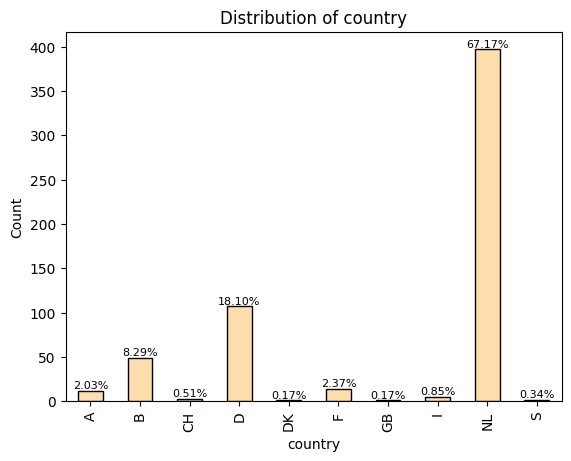

In [5]:
plot_bar_chart("country", stations)

In [6]:
stations_nl = filter_by_column_value(stations, "country", "NL")

In [7]:
len(stations_nl)
#Missing 4 stations - will check if merging with main dataset will produce any null values

397

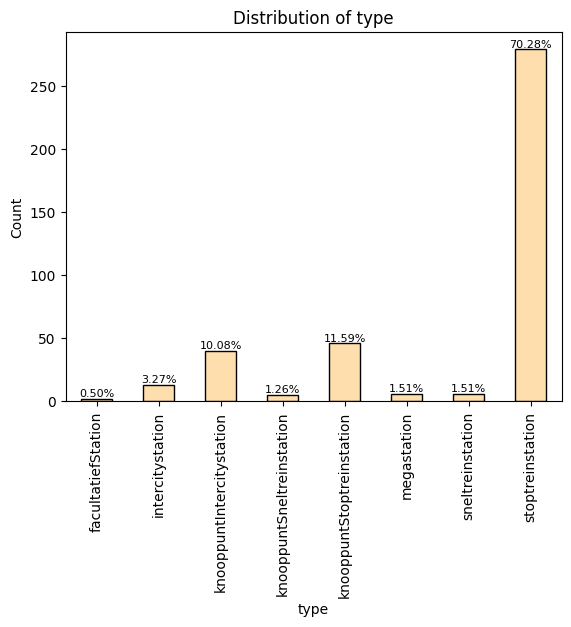

In [8]:
plot_bar_chart("type", stations_nl)

In [9]:
stations_mega = filter_by_column_value(stations_nl, "type", "megastation")

In [10]:
print(stations_mega)

      id code      uic  name_short       name_medium           name_long  \
30    43  ASD  8400058  Amsterdm C      Amsterdam C.  Amsterdam Centraal   
141  214  GVC  8400282  Den Haag C       Den Haag C.   Den Haag Centraal   
181  168  EHV  8400206  Eindhovn C      Eindhoven C.  Eindhoven Centraal   
442  411  RTD  8400530  Rotterdm C      Rotterdam C.  Rotterdam Centraal   
460  428  SHL  8400561    Schiphol  Schiphol Airport    Schiphol Airport   
505  467   UT  8400621   Utrecht C        Utrecht C.    Utrecht Centraal   

                   slug country         type    geo_lat   geo_lng  
30   amsterdam-centraal      NL  megastation  52.378887  4.900278  
141   den-haag-centraal      NL  megastation  52.080276  4.325000  
181  eindhoven-centraal      NL  megastation  51.443333  5.481389  
442  rotterdam-centraal      NL  megastation  51.924999  4.468889  
460    schiphol-airport      NL  megastation  52.309444  4.761944  
505    utrecht-centraal      NL  megastation  52.088890  5.

In [11]:
stations_nl = stations_nl.drop(["name_short", "name_medium", "uic", "slug"], axis = 1)

In [12]:
stations_nl.head()

,id,code,name_long,country,type,geo_lat,geo_lng
0,266,HT,'s-Hertogenbosch,NL,knooppuntIntercitystation,51.690480,5.293620
1,269,HTO,'s-Hertogenbosch Oost,NL,stoptreinstation,51.700554,5.318333
2,227,HDE,'t Harde,NL,stoptreinstation,52.409168,5.893611
5,51,ATN,Aalten,NL,stoptreinstation,51.921327,6.578627
6,5,AC,Abcoude,NL,stoptreinstation,52.278500,4.977000


In [13]:
count_nulls(stations_nl, "geo_lng")

Nulls: 0


0

In [14]:
stations_nl.to_csv('preprocessed_data/stations_clean_v1.csv', index=False)

## Extra - calculate trains per station in 2024
Calculate all trains, all entries, all train companies

In [17]:
main_dataset_unprocessed = pd.read_csv("datasets/train_information_main_2024.csv")


In [18]:
main_dataset_unprocessed = main_dataset_unprocessed.dropna(subset=["Stop:Station code"])

In [21]:
station_counts = main_dataset_unprocessed["Stop:Station code"].value_counts()

# 2. Map counts to stations_nl, fill missing stations with 0
stations_nl["Nr trains 2024"] = stations_nl["code"].map(station_counts).fillna(0).astype(int)

In [25]:
stations_nl = stations_nl.sort_values("Nr trains 2024", ascending=False)

stations_nl.head(15)

,id,code,name_long,country,type,geo_lat,geo_lng,Nr trains 2024
505,467,UT,Utrecht Centraal,NL,megastation,52.088890,5.110278,478676
30,43,ASD,Amsterdam Centraal,NL,megastation,52.378887,4.900278,404915
36,50,ASS,Amsterdam Sloterdijk,NL,knooppuntIntercitystation,52.388889,4.837778,291613
442,411,RTD,Rotterdam Centraal,NL,megastation,51.924999,4.468889,285306
460,428,SHL,Schiphol Airport,NL,megastation,52.309444,4.761944,278134
589,532,ZL,Zwolle,NL,knooppuntIntercitystation,52.504723,6.091944,261619
141,214,GVC,Den Haag Centraal,NL,megastation,52.080276,4.325000,244257
51,6,AH,Arnhem Centraal,NL,knooppuntIntercitystation,51.985001,5.899167,234542
328,308,LEDN,Leiden Centraal,NL,knooppuntIntercitystation,52.166111,4.481667,230761
226,204,GN,Groningen,NL,knooppuntIntercitystation,53.210556,6.564722,215052


In [ ]:
stations_nl.to_csv("preprocessed_data/stations_clean_v2.csv", index=False)